# Testing the WOfS algorithm
It can be tedious to test-run this wofs package as a whole: adjusting configurations, installing the module, preparing and connecting between appropriate databases (populated with real input data but shielding the production database from test output), perhaps scheduling compute jobs, querying (and exporting) resulting output, and comparing against data elsewhere. (*In future, this process may be simplified by use of virtual-products and a separate reification-app.*)

This notebook patches into the module, to test only the core algorithm (not the packaging). For example:
- run on an arbitrary "postage-stamp"
- run on an arbitrary tile
- save results in a portable format for external analysis

It assumes the environment is configured for accessing the production database, but will not write to the production data holdings.

In [1]:
import sys
sys.path.insert(0,'..') # to import wofs (and preferentially from here)
import datacube
dc = datacube.Datacube()

## Tiles
Concept here is to patch into the app's methods for generating tasks and for performing a task.

In [2]:
import datetime
time = datacube.model.Range(datetime.datetime(1987,9,25,23,20,5), datetime.datetime(1987,9,25,23,20,25))
import yaml
import wofs.wofs_app
# dry run => do not write the product def to the index
config = yaml.load(open('../config/wofs_albers.yaml'))
config['location'] = './' # where to write tiles
config = wofs.wofs_app.make_wofs_config(dc.index, config, dry_run=True) # dry run => don't insert definition into database
tasks = list(wofs.wofs_app.generate_tasks(dc.index, config, time=time))
len(tasks)

0

Note, maybe there are too few tasks outstanding because they've already been done. We can trick it to do them again.

In [3]:
config['product_definition']['name'] = 'dummy'
config = wofs.wofs_app.make_wofs_config(dc.index, config, dry_run=True) # dry run => don't insert definition into database
tasks = list(wofs.wofs_app.generate_tasks(dc.index, config, time=time))
len(tasks)

9

In [4]:
[task['tile_index'] for task in tasks[:5]] # inspect a few

[(18, -26, numpy.datetime64('1987-09-25T23:20:22.500000000')),
 (20, -26, numpy.datetime64('1987-09-25T23:20:22.500000000')),
 (19, -26, numpy.datetime64('1987-09-25T23:20:22.500000000')),
 (20, -27, numpy.datetime64('1987-09-25T23:20:22.500000000')),
 (18, -27, numpy.datetime64('1987-09-25T23:20:22.500000000'))]

In [5]:
def do_task(config=config, **task):
    """Remove output file first if it already exists"""
    try:
        task['file_path'].unlink()
    except FileNotFoundError:
        pass
    return wofs.wofs_app.do_wofs_task(config=config, **task)        

In [6]:
import timeit
t0 = timeit.default_timer()
result = do_task(**tasks[0]) # do one (should write a file but not index it)
timeit.default_timer() - t0

../wofs/classifier.py:67: RuntimeWarning: divide by zero encountered in true_divide
  c = (a - b) / (a + b)


15.579870926216245

In [7]:
result

[Dataset <id=37862423-5419-44aa-9f24-3ad9ea00a20a type=dummy location=/g/data1/u46/users/brl654/datacube/wofs/tests/LS5_TM_WATER/18_-26/LS5_TM_WATER_3577_18_-26_19870925232022500000.nc>]

The usual task is to write the dataset to a file (in preparation for indexing), not to retain it in memory (amenable to visualisation).

Now, to visualise that data!

## Postage-stamp
Concept is to patch into the core science algorithm. So must provide NBAR, PQ and DSM data.

For example, Minindee lakes.

In [8]:
timerange = ('2015-01-01','2015-02-01')
spatialquery = dict(lat=(-32.72,-32.17), lon=(141.99, 142.68))
nbar = dc.load(product='ls8_nbar_albers', time=timerange, **spatialquery)
len(nbar.time)

8

In [9]:
pq = dc.load(product='ls8_pq_albers', time=timerange, like=nbar)
len(pq.time) == len(nbar.time)

True

In [10]:
dsm = dc.load(product='dsm1sv10', like=nbar, time=('1900-01-01','2100-01-01'))

In [12]:
import wofs.wofls
w = [wofs.wofls.woffles(nbar.isel(time=i), pq.isel(time=i), dsm.isel(time=0)) for i in range(nbar.time.size)]

../wofs/classifier.py:67: RuntimeWarning: divide by zero encountered in true_divide
  c = (a - b) / (a + b)


In [23]:
import xarray
water = xarray.concat(w, nbar.time)
dry = (water==0)
wet = (water==128)
clear = wet | dry
freq = wet.sum(dim='time') / clear.sum(dim='time')
freq

/g/data1/u46/users/brl654/tools/python/anaconda/install/envs/pyramid/lib/python3.5/site-packages/xarray-0.8.2-py3.5.egg/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


<xarray.DataArray (y: 2660, x: 2765)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Coordinates:
  * x        (x) float64 9.284e+05 9.284e+05 9.284e+05 9.284e+05 9.285e+05 ...
  * y        (y) float64 -3.543e+06 -3.543e+06 -3.543e+06 -3.543e+06 ...

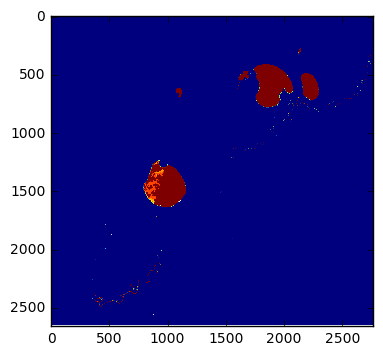

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(freq.data)